# Классификация изображений

### **Задание**

Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989.

В этом задании будем классифицировать персонажей, проживающих в Спрингфилде.

В тестовой выборке 991 картинка, для которых требуется предсказать класс.

Метрика, которую мф будем оптимизировать - `f1-score` (по условиям конкурса)

## Шаг 1. Установка зависимостей

#### Установим необходимые библиотеки и проверим доступность CUDA

In [ ]:
import torch
import numpy as np

In [ ]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
!nvidia-smi

Tue Nov 18 06:05:14 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   54C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [1]:
import pickle
import pandas as pd
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from torchvision.transforms import v2
import torchvision.models as models

import torchsummary

from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline
import random
import shutil

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


#### Проверим версии Python и библиотек

Версии питона и библиотек, на которых работал эталонный ноутбук (будем вычислять результаты на Kaggle):

- Python 3.12.12
- torch version: 2.8.0+cu126
- torchvision version: 0.23.0+cu126
- tqdm version: 4.67.1
- matplotlib version: 3.10.0
- seaborn version: 0.13.2
- Pillow version: 11.3.0

Посмотрим, какие версии установлены:

In [ ]:
!python --version
from importlib.metadata import version
for b in ['torch', 'torchvision', 'tqdm', 'matplotlib', 'seaborn', 'Pillow']:
    print(b + ' version: '+ version(b))

Python 3.12.12
torch version: 2.8.0+cu126
torchvision version: 0.23.0+cu126
tqdm version: 4.67.1
matplotlib version: 3.10.0
seaborn version: 0.13.2
Pillow version: 11.3.0


 #### Определим константы

In [ ]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']

# работаем на видеокарте
DEVICE = torch.device("cuda")

# определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('/content/train') #Path('./data/train/')
TEST_DIR = Path('/content/testset') #Path('./data/testset')

# параметры нормировки изображений по трем каналам перед подачей в модель
NORMALIZE_MEAN = [0.485, 0.456, 0.406]
NORMALIZE_STD = [0.229, 0.224, 0.225]

# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = [224, 224]

## Шаг 2. Загрузка и обработка данных

In [2]:
from google.colab import files
print("Загрузи файл kaggle.json с твоего Kaggle аккаунта:")
files.upload()

Загрузи файл kaggle.json с твоего Kaggle аккаунта:


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"annawinterv31","key":"b033e147a3ded6491f8c219a867d5950"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c journey-to-springfield1

 98% 508M/521M [00:01<00:00, 346MB/s]
100% 521M/521M [00:01<00:00, 442MB/s]


In [5]:
!unzip -q journey-to-springfield1.zip

In [ ]:
#!gdown 1RxBQiZgRAfio2tWhEE7lzZ6IaJzLheH1

In [ ]:
#!unzip -q /content/journey-springfield.zip

Посмотрите на структуру файлов в папках train и testset.

В train лежат данные, которые мы будем использовать для обучения модели. Изображения персонажей разложены по папкам, которые названы по именам персонажей. Названия папок мы в дальнейшем будет использовать в качестве текстовых меток классов.

В testset находятся изображения, для которых вам надо будет сделать прогноз наиболее вероятного класса.


In [ ]:
TRAIN_DIR = Path('/content/train/simpsons_dataset')

In [ ]:
# Посмотрим структуру train
print("TRAIN структура:")
for path in TRAIN_DIR.glob('*/*'):
    print(path)
    break

# Посмотрим структуру test
print("\nTEST структура:")
for path in TEST_DIR.glob('*'):
    print(path)
    break

# Посчитать папки (классы) в train
print()
num_classes = len([x for x in TRAIN_DIR.glob('*') if x.is_dir()])
print(f"Количество классов: {num_classes}")

# Файлов в train
train_files = sum(1 for _ in TRAIN_DIR.glob('*/*.jpg'))
print(f"Train файлов: {train_files}")

# Файлов в test
test_files = sum(1 for _ in Path('/content/testset/testset').glob('*.jpg'))
print(f"Test файлов: {test_files}")

TRAIN структура:
/content/train/simpsons_dataset/chief_wiggum/pic_0310.jpg

TEST структура:
/content/testset/testset

Количество классов: 42
Train файлов: 20933
Test файлов: 991


Для обращения к файлам сформируем списки имен файлов обучающей+валидационнной и тестовой выборок.


In [ ]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

Кодировать имена персонажей в числовые метки класса и обратно будем при помощи `LabelEncoder`.

Для train выборки сформируем список текстовых меток всех изображений - имя родительской директории, которая одновременно является и именем персонажа.

In [ ]:
label_encoder = LabelEncoder()

train_val_labels = [path.parent.name for path in train_val_files]

label_encoder.fit(train_val_labels)

LabelEncoder()

Разделим train выборку на обучающую и валидационнную части. Для того, чтобы персонажи были пропорционально представлены в обучающей и валидационнной подвыборках, применим стратификацию по меткам класса.

In [ ]:
from sklearn.model_selection import train_test_split

train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

#### Создадим Datasets и Dataloaders

У нас есть набор файлов-картинок, которые требуется преобразовать в тензоры, и добавить к ним числовые метки классов.

Реализуем это с помощью созданного нами класса `SimpsonsDataset`, который из списка файлов создаст необходимый нам Dataset.  

In [ ]:
class SimpsonsDataset(Dataset):
    def __init__(self, files, label_encoder, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode
        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.label_encoder = label_encoder
        self.len_ = len(self.files)

    def __len__(self):
        return self.len_

    def __getitem__(self, index):
        x = self.load_image(self.files[index])
        x = self.transform_images_to_tensors(x)

        if self.mode == 'test':
            return x
        else:
            path = self.files[index]
            y = self.label_encoder.transform([path.parent.name,]).item()
            return x, y

    # принимает путь к файлу изображения и возвращает само изображение
    def load_image(self, file):
        image = Image.open(file)
        image.load()
        return image

    # преобразует изображение в тензор
    def transform_images_to_tensors(self, image):
      if self.mode == 'train':
        transform = v2.Compose([
            v2.PILToTensor(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
            #v2.ColorJitter(brightness = 0.1, contrast = 0.1, saturation = 0.1),
            v2.Resize(RESCALE_SIZE),
          ])
      else:
        transform = v2.Compose([
            v2.PILToTensor(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
            v2.Resize(RESCALE_SIZE),
          ])

      tensor_transformed = transform(image)
      return(tensor_transformed)


In [ ]:
train_dataset = SimpsonsDataset(train_files, label_encoder = label_encoder, mode='train')
val_dataset = SimpsonsDataset(val_files, label_encoder, mode='val')

In [ ]:
batch_size = 64

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
loaders = {'train':train_loader, 'val': val_loader}

#### Посмотрим на изображения персонажей

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

Проверим, как работает наша функция. Возьмем один батч из лоадера и подадим на вход функции первый тензор из этого батча. Заодно посмотрим, как работает кодировщик меток класса.

Числовая метка класса: 0
Текстовая метка класса: ['abraham_grampa_simpson']


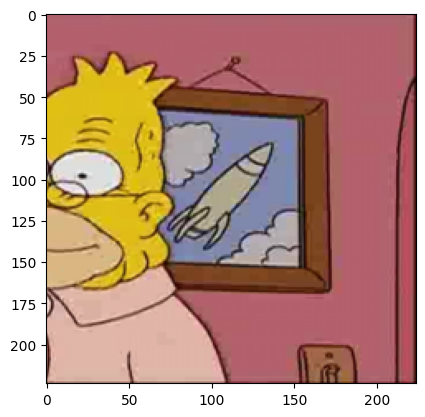

In [ ]:
image_tensor, label = next(iter(train_loader))
print(f"Числовая метка класса: {label[0]}")
print(f"Текстовая метка класса: {label_encoder.inverse_transform([label[0],])}")
imshow(image_tensor[0])


## Шаг 3. Построение нейросети

Для начала создадим простую модель

#### Модель

In [ ]:
class SimpleCnn(nn.Module):
    """
    Простая сверточная нейронная сеть для классификации изображений,
    она состоит из 5 сверточных слоев, каждый из которых
    включает в себя операцию свертки, функцию активации ReLU и операцию
    пулинга (max-pooling). На выходе используется полносвязный слой
    для классификации на заданное количество классов.
    """

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.out = nn.Linear(96 * 5 * 5, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

*Описание слоев*:

1. размерность входа: $3\times 224 \times 224$
2. размерность после 1-го слоя (Conv2d + ReLU + MaxPool2d):  $8 \times 111 \times 111$
3. после 2-го слоя: $16 \times 54 \times 54$
4. после 3-го слоя: $32 \times 26 \times 26$
5. после 4-го слоя: $64 \times 12 \times 12$
6. после 5-го слоя: $96 \times 5 \times 5$
7. после полносвязного слоя (выход модели): количество классов

In [ ]:
model_simple_cnn = SimpleCnn(n_classes = len(np.unique(train_val_labels)))
model_simple_cnn.to(DEVICE)
torchsummary.summary(model_simple_cnn, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 222, 222]             224
              ReLU-2          [-1, 8, 222, 222]               0
         MaxPool2d-3          [-1, 8, 111, 111]               0
            Conv2d-4         [-1, 16, 109, 109]           1,168
              ReLU-5         [-1, 16, 109, 109]               0
         MaxPool2d-6           [-1, 16, 54, 54]               0
            Conv2d-7           [-1, 32, 52, 52]           4,640
              ReLU-8           [-1, 32, 52, 52]               0
         MaxPool2d-9           [-1, 32, 26, 26]               0
           Conv2d-10           [-1, 64, 24, 24]          18,496
             ReLU-11           [-1, 64, 24, 24]               0
        MaxPool2d-12           [-1, 64, 12, 12]               0
           Conv2d-13           [-1, 96, 10, 10]          55,392
             ReLU-14           [-1, 96,

## Шаг 4. Функции для работы с моделью

#### Пишем функцию для работы с моделью

Метрика, которую необходимо оптимизировать в конкурсе -- `f1-score`.

In [ ]:
from sklearn.metrics import f1_score
# f1 = f1_score(actual_labels, y_predicted, average='micro')

Напишем следующие функции:
- для обучения модели на одной эпохе
- для валидации модели на одной эпохе
- для реализации полного цикла обучения


In [ ]:
# обучение модели на одной эпохе
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(train_loader)
    return epoch_loss, all_preds, all_labels

In [ ]:
# валидации модели на одной эпохе
def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(val_loader)
    return epoch_loss, all_preds, all_labels

In [ ]:
# реализации полного цикла обучения
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    train_losses = []
    val_losses = []
    train_f1_scores = []
    val_f1_scores = []

    for epoch in range(epochs):
        train_loss, train_preds, train_labels = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_preds, val_labels = validate_epoch(model, val_loader, criterion, device)

        train_f1 = f1_score(train_labels, train_preds, average='micro')
        val_f1 = f1_score(val_labels, val_preds, average='micro')

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_f1_scores.append(train_f1)
        val_f1_scores.append(val_f1)

        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'  Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}')
        print(f'  Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}')

    return train_losses, val_losses, train_f1_scores, val_f1_scores

## Шаг 5. Применение модели к данным

#### Применение модели к данным

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_simple_cnn.parameters(), lr = 1e-3)

Запусткаем обучение сети

In [ ]:
# Обучаем начальную модель с ранней остановкой
best_val_f1 = 0
patience = 2
epochs_no_improve = 0

train_losses = []
val_losses = []
train_f1_scores = []
val_f1_scores = []

for epoch in range(10):
    train_loss, train_preds, train_labels = train_epoch(model_simple_cnn, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_preds, val_labels = validate_epoch(model_simple_cnn, val_loader, criterion, DEVICE)

    train_f1 = f1_score(train_labels, train_preds, average='micro')
    val_f1 = f1_score(val_labels, val_preds, average='micro')

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_f1_scores.append(train_f1)
    val_f1_scores.append(val_f1)

    print(f'Epoch {epoch+1}:')
    print(f'  Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}')
    print(f'  Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}')

    # Ранняя остановка
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        epochs_no_improve = 0
        torch.save(model_simple_cnn.state_dict(), 'best_simple_cnn.pth')
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Ранняя остановка на эпохе {epoch+1}")
        break

# Загружаем лучшие веса
model_simple_cnn.load_state_dict(torch.load('best_simple_cnn.pth'))

Epoch 1:
  Train Loss: 2.5579, Train F1: 0.2883
  Val Loss: 1.9035, Val F1: 0.4838
Epoch 2:
  Train Loss: 1.4949, Train F1: 0.5935
  Val Loss: 1.2525, Val F1: 0.6635
Epoch 3:
  Train Loss: 0.9299, Train F1: 0.7414
  Val Loss: 1.0373, Val F1: 0.7268
Epoch 4:
  Train Loss: 0.6495, Train F1: 0.8162
  Val Loss: 0.9311, Val F1: 0.7660
Epoch 5:
  Train Loss: 0.4597, Train F1: 0.8695
  Val Loss: 0.9407, Val F1: 0.7866
Epoch 6:
  Train Loss: 0.3187, Train F1: 0.9071
  Val Loss: 0.9587, Val F1: 0.7864
Epoch 7:
  Train Loss: 0.2301, Train F1: 0.9304
  Val Loss: 0.9967, Val F1: 0.8005
Epoch 8:
  Train Loss: 0.1692, Train F1: 0.9489
  Val Loss: 1.1511, Val F1: 0.7885
Epoch 9:
  Train Loss: 0.1399, Train F1: 0.9561
  Val Loss: 1.2306, Val F1: 0.7979
Ранняя остановка на эпохе 9


<All keys matched successfully>

Так интересно, сначала не предусматривалась ранняя остановка и количество эпох было фиксированным (10) и модель очень быстро переобучилась:

``` python
Epoch 1/10:
  Train Loss: 2.5388, Train F1: 0.3001
  Val Loss: 1.8680, Val F1: 0.4904
Epoch 2/10:
  Train Loss: 1.4761, Train F1: 0.5967
  Val Loss: 1.2896, Val F1: 0.6567
Epoch 3/10:
  Train Loss: 0.9340, Train F1: 0.7414
  Val Loss: 1.0287, Val F1: 0.7323
Epoch 4/10:
  Train Loss: 0.6244, Train F1: 0.8251
  Val Loss: 0.9064, Val F1: 0.7623
Epoch 5/10:
  Train Loss: 0.4214, Train F1: 0.8762
  Val Loss: 0.9587, Val F1: 0.7744
Epoch 6/10:
  Train Loss: 0.2896, Train F1: 0.9142
  Val Loss: 1.1029, Val F1: 0.7757
Epoch 7/10:
  Train Loss: 0.2073, Train F1: 0.9364
  Val Loss: 1.1398, Val F1: 0.7895
Epoch 8/10:
  Train Loss: 0.1463, Train F1: 0.9546
  Val Loss: 1.2438, Val F1: 0.7889
Epoch 9/10:
  Train Loss: 0.1214, Train F1: 0.9619
  Val Loss: 1.2995, Val F1: 0.7780
Epoch 10/10:
  Train Loss: 0.1051, Train F1: 0.9653
  Val Loss: 1.3836, Val F1: 0.7874
  ```

Потому было решено реализовать вариант преждевременного завершения, если к тому будут предпосылки.

В итоге, модель прошла почти весь путь  и при этом показания первоначальной модели были даже чуть лучше - `0,9256` против `0,9224` на текущей модели.

**Вывод:**

Early stopping - это палка о двух концах. Иногда он предотвращает переобучение, иногда - останавливает слишком рано.

Нужно подбирать параметры под конкретную задачу!

In [ ]:
#train_losses, val_losses, train_f1_scores, val_f1_scores = train_model(
#    model=model_simple_cnn,
#    train_loader=train_loader,
#    val_loader=val_loader,
#    criterion=criterion,
#    optimizer=optimizer,
#    device=DEVICE,
#    epochs=10
#)

Строим график динамики метрик модели по ходу обучения

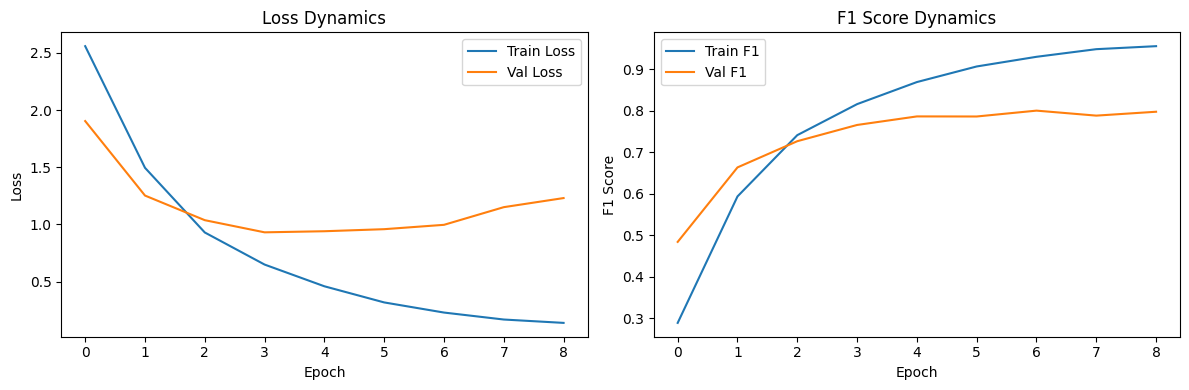

In [ ]:
# график динамики метрик модели по ходу обучения
plt.figure(figsize=(12, 4))

# График loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Dynamics')

# График F1
plt.subplot(1, 2, 2)
plt.plot(train_f1_scores, label='Train F1')
plt.plot(val_f1_scores, label='Val F1')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.title('F1 Score Dynamics')

plt.tight_layout()
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Сделаем визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах.

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

@torch.no_grad()
def show_images2(n_rows, n_cols, dataset, model):
  # функция выводит изображения в n_rows рядов и n_cols столбцов
  fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 4, n_rows * 4), \
                        sharey=True, sharex=True)

  for fig_x in axs.flatten():
    random_characters = int(np.random.uniform(0, len(dataset)))
    im_val, label = dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(), \
                             label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), title=img_label, plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    font0 = FontProperties()
    font = font0.copy()

    # наша модель возвращает логиты, поэтому для получения вероятностей классов не забываем применить softmax:
    prob_pred = nn.functional.softmax(model(im_val.unsqueeze(0).to(DEVICE)), dim = -1).cpu().numpy()

    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = " ".join(map(lambda x: x.capitalize(), \
                             label_encoder.inverse_transform([y_pred])[0].split('_')))
    predicted_text = "{}:\n {:.1f}%".format(predicted_label, predicted_proba)

    fig_x.add_patch(patches.Rectangle((0, 190), 7*len(predicted_label), 25,color='white'))
    fig_x.text(2, 195, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')
    fig_x.set_axis_off()

  return None

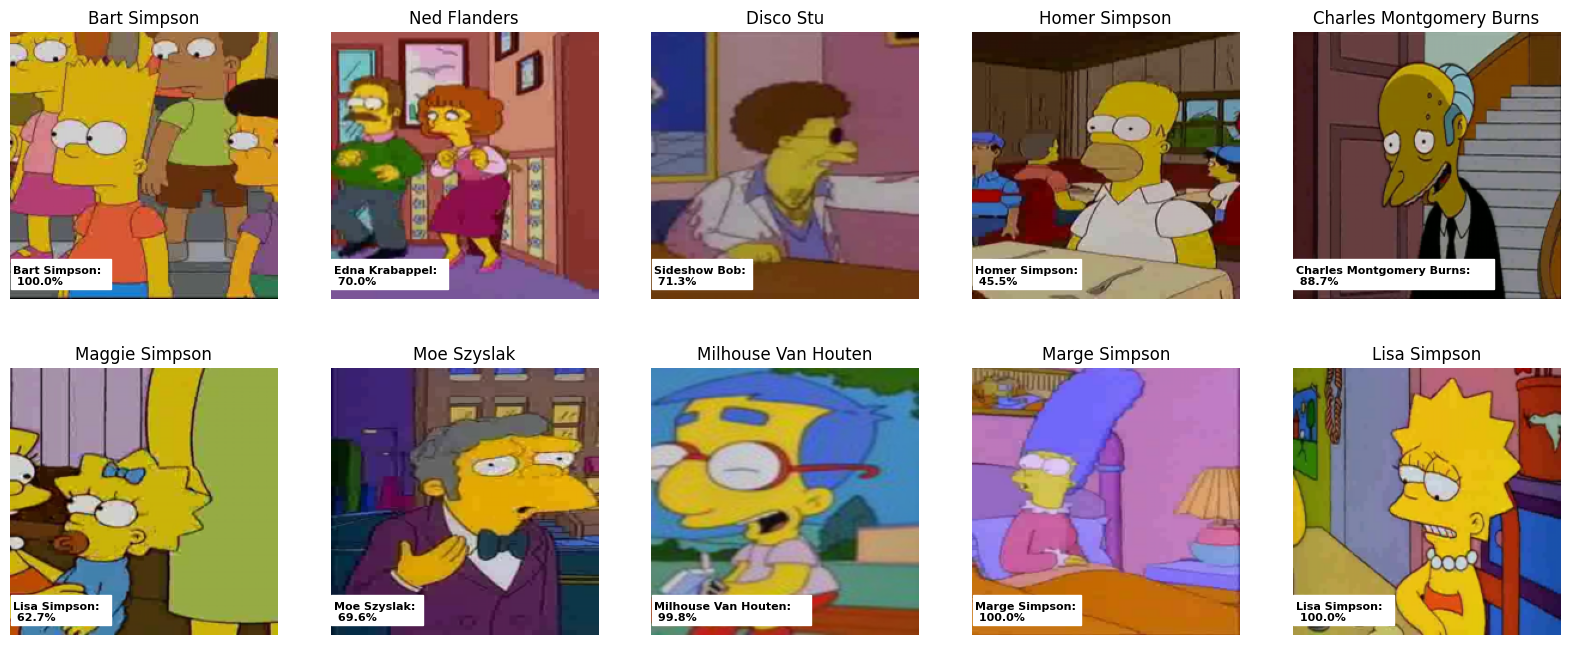

In [ ]:
show_images2(n_rows = 2, n_cols = 5, dataset = val_dataset, model = model_simple_cnn)

## Шаг 6. Submit на Kaggle

Создадим loader для тестовых данных

In [ ]:
test_dataset = SimpsonsDataset(test_files, label_encoder = label_encoder, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)

Воспользуемся функцией predict, которая возвращает предсказанные числовые метки для всех объектов в лоадере.

In [ ]:
def predict(model, loader):
    model.eval()
    all_predictions = torch.tensor([]).to(DEVICE).int()
    print("Test mode...")
    for inputs in tqdm_notebook(loader):
        inputs = inputs.to(DEVICE)

        with torch.no_grad():
            outputs = model(inputs)

            predictions = outputs.argmax(-1).int()
            all_predictions = torch.cat((all_predictions, predictions), 0)
    return all_predictions.cpu()

Получем предсказание меток классов для тестовых данных:

In [ ]:
predicted_numeric_labels = predict(model_simple_cnn, test_loader)

Test mode...


  0%|          | 0/16 [00:00<?, ?it/s]

и преобразуем их в текстовые метки:

In [ ]:
predicted_text_labels = label_encoder.inverse_transform(predicted_numeric_labels)

Загрузим пример файла для загрузки на Kaggle (проверьте путь, по которому у вас лежит файл sample_submission.csv и при необходимости скорректируйте путь в коде ниже):

In [ ]:
import pandas as pd
sample_submission = pd.read_csv("/content/sample_submission.csv")
sample_submission.head()

Id      Expected
0  img0.jpg  bart_simpson
1  img1.jpg  bart_simpson
2  img2.jpg  bart_simpson
3  img3.jpg  bart_simpson
4  img4.jpg  bart_simpson

In [ ]:
my_submission = pd.DataFrame({'Id': [path.name for path in test_files], 'Expected': predicted_text_labels})
my_submission.head()

Id                Expected
0    img0.jpg            nelson_muntz
1    img1.jpg            bart_simpson
2   img10.jpg            ned_flanders
3  img100.jpg            chief_wiggum
4  img101.jpg  apu_nahasapeemapetilon

In [ ]:
my_submission.to_csv('simple_cnn_baseline.csv', index=False)

### Результат на тестовых данных на Kaggle показал:

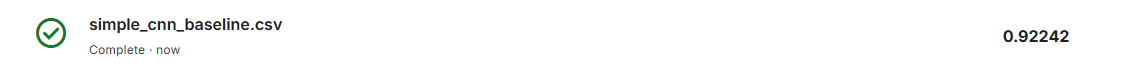

**Вывод:**

---

Мы сделали простую сверточную сеть и смогли отправить сабмит, но получившийся score нас явно не устраивает.

Вот некоторые направления, которые хотим попробовать:

1. Работа с датасетом:
* Увеличение разнообразия обучающей выборки при помощи аугментации и работа с небольшими классами

2. Работа с архитектурой сети:
* учим дольше и изменяем (подбираем) гиперпараметры

3. Можно попробовать файнтютинг и трансферлёнинг:

4. Улучшение оптимизации:

5. Наконец, возможно, стоит подумать об ансамблях (но только подумать!!!)



Дла начала изучим сбалансированность датасета.

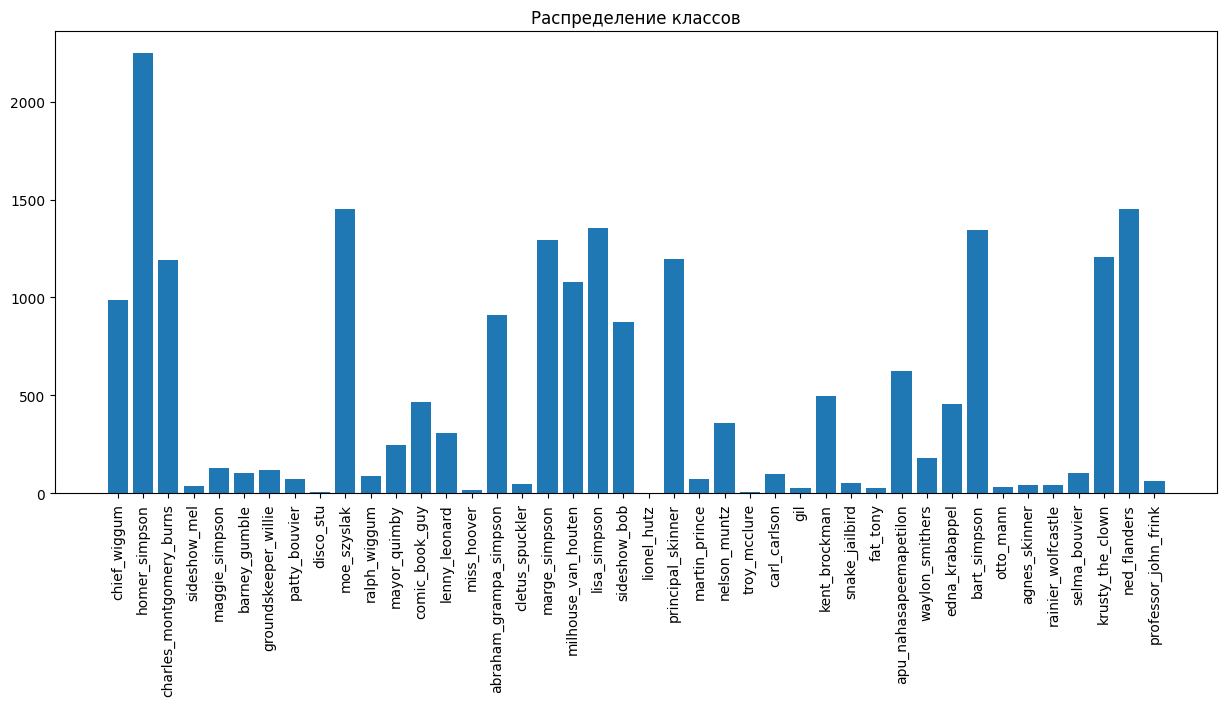

Самые маленькие классы:
lionel_hutz: 3 изображений
disco_stu: 8 изображений
troy_mcclure: 8 изображений
miss_hoover: 17 изображений
gil: 27 изображений
fat_tony: 27 изображений
otto_mann: 32 изображений
sideshow_mel: 40 изображений
agnes_skinner: 42 изображений
rainier_wolfcastle: 45 изображений

Всего классов: 42
Медианное количество: 181


In [ ]:
import matplotlib.pyplot as plt

TRAIN_DIR = Path('/content/train/simpsons_dataset')

# 1. Дисбаланс классов
class_counts = {}
for char_dir in TRAIN_DIR.glob('*'):
    if char_dir.is_dir():
        count = len(list(char_dir.glob('*.jpg')))
        class_counts[char_dir.name] = count

# График распределения
plt.figure(figsize=(15, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=90)
plt.title('Распределение классов')
plt.show()

# 2. Самые маленькие классы
sorted_classes = sorted(class_counts.items(), key=lambda x: x[1])
print("Самые маленькие классы:")
for class_name, count in sorted_classes[:10]:
    print(f"{class_name}: {count} изображений")

print(f"\nВсего классов: {len(class_counts)}")
print(f"Медианное количество: {sorted([x[1] for x in class_counts.items()])[len(class_counts)//2]}")

**Вывод:**

Виден значительный **дисбаланс в распределении классов** датасета.

Наблюдается разброс от `3` до `400+` изображений на персонажа, при медианном значении 181.

Наименее представленные классы `lione_lutz, disco_stu, troy_mcclure` требуют дополнительной аугментации / применения техник балансировки для улучшения качества их классификации.

Теперь посмотрим ошибки модели.

Ошибок: 1044


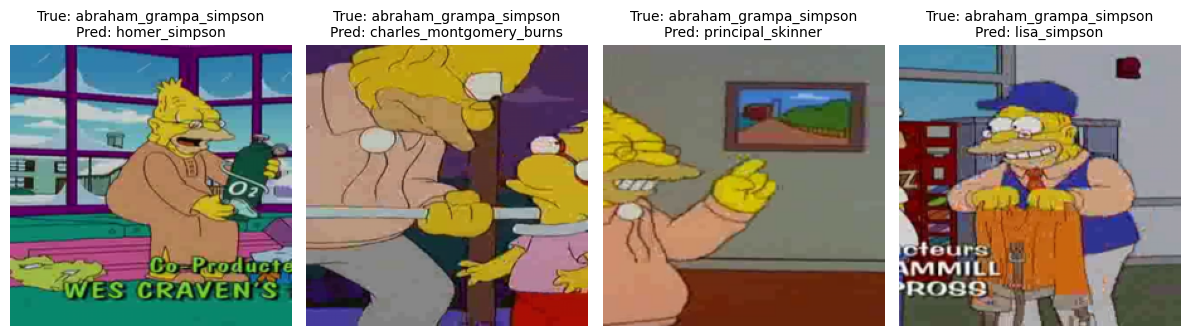

In [ ]:
# немного изменим
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Возьмем валидационный датасет
val_dataset = SimpsonsDataset(val_files, label_encoder, mode='val')

# Предсказания на валидации
model_simple_cnn.eval()
incorrect_samples = []

with torch.no_grad():
    for i in range(len(val_dataset)):
        img, true_label = val_dataset[i]
        pred = model_simple_cnn(img.unsqueeze(0).to(DEVICE))
        pred_label = pred.argmax(1).item()

        if pred_label != true_label:
            incorrect_samples.append({
                'image': img,
                'true': true_label,
                'pred': pred_label
            })

# Покажем несколько ошибок
print(f"Ошибок: {len(incorrect_samples)}")

fig, axes = plt.subplots(1, 4, figsize=(12, 4))
for i, ax in enumerate(axes):
    if i < min(4, len(incorrect_samples)):
        sample = incorrect_samples[i]
        true_name = label_encoder.inverse_transform([sample['true']])[0]
        pred_name = label_encoder.inverse_transform([sample['pred']])[0]

        # Показываем изображение
        img = sample['image'].numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        ax.imshow(img)
        ax.set_title(f"True: {true_name}\nPred: {pred_name}", fontsize=10)
        ax.axis('off')

plt.tight_layout()
plt.show()

**Вывод:**

Анализ ошибок показал, что модель чаще всего путает визуально похожих персонажей (abraham_grampa_simpson и homer_simpson), что указывает на необходимость улучшения способности модели различать тонкие детали.


Мы не сможем просмотреть все изображения для проверка качества данных, но на рандомной проверке отклонений не обнаружено.

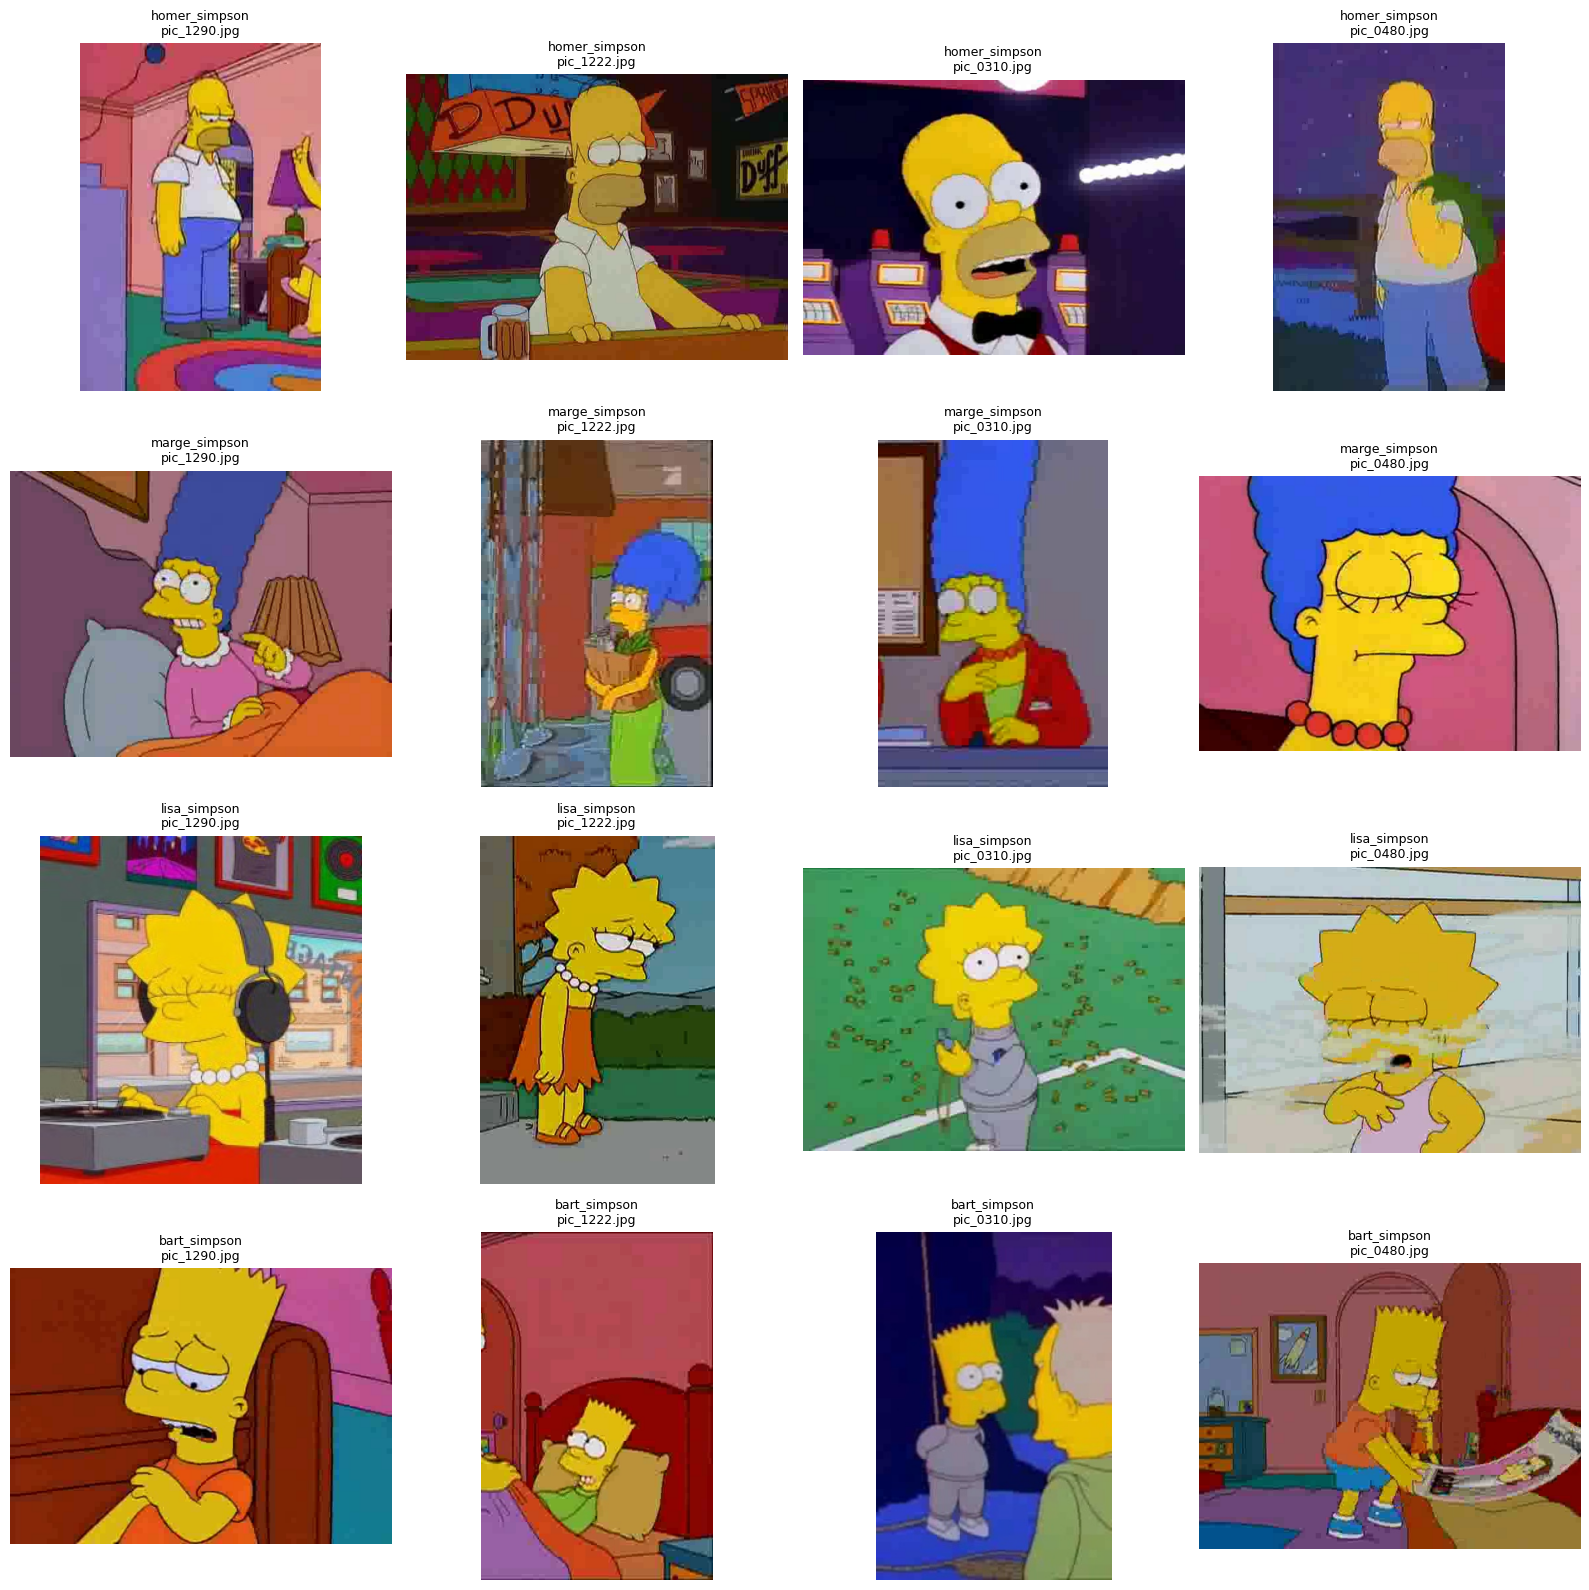

In [ ]:
main_characters = ["homer_simpson", "marge_simpson", "lisa_simpson", "bart_simpson"]

fig, axes = plt.subplots(4, 4, figsize=(16, 16))
и
for row, character in enumerate(main_characters):
    class_dir = Path('/content/train/simpsons_dataset') / character
    images = list(class_dir.glob('*.jpg'))[:4]  # первые 4 изображения

    for col, img_path in enumerate(images):
        img = Image.open(img_path)
        axes[row, col].imshow(img)
        axes[row, col].set_title(f'{character}\n{img_path.name}', fontsize=9)
        axes[row, col].axis('off')

plt.tight_layout()
plt.show()


**Переход к улучшениям:**  

Попробуем осуществить следующие действия:

- Transfer Learning на основе предобученной ResNet18
- Расширенную аугментацию данных
- Fine-tuning всех слоёв модели

Это позволит модели использовать уже выученные признаки и адаптироваться к специфике датасета.

In [ ]:
# Загрузка предобученной ResNet18 и меняем последний слой на наши 42 класса

model_resnet = models.resnet18(pretrained=True)
model_resnet.fc = nn.Linear(model_resnet.fc.in_features, len(np.unique(train_val_labels)))
model_resnet = model_resnet.to(DEVICE)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 73.1MB/s]


In [ ]:
# Аугментация для train
train_transforms = v2.Compose([
    v2.Resize(RESCALE_SIZE),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(degrees=10),
    v2.ColorJitter(brightness=0.2, contrast=0.2),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
])

val_transforms = v2.Compose([
    v2.Resize(RESCALE_SIZE),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
])

In [ ]:
# Обновленный Dataset с трансформациями
class SimpsonsDataset(Dataset):
    def __init__(self, files, label_encoder, mode, transform=None):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode
        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.label_encoder = label_encoder
        self.len_ = len(self.files)
        self.transform = transform

    def __len__(self):
        return self.len_

    def __getitem__(self, index):
        x = self.load_image(self.files[index])

        if self.transform:
            x = self.transform(x)
        else:
            x = self.transform_images_to_tensors(x)

        if self.mode == 'test':
            return x
        else:
            path = self.files[index]
            y = self.label_encoder.transform([path.parent.name]).item()
            return x, y

    def load_image(self, file):
        image = Image.open(file)
        image.load()
        return image

    # Старый метод на случай, если transform=None
    def transform_images_to_tensors(self, image):
        if self.mode == 'train':
            transform = v2.Compose([
                v2.PILToTensor(),
                v2.ToDtype(torch.float32, scale=True),
                v2.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
                v2.Resize(RESCALE_SIZE),
            ])
        else:
            transform = v2.Compose([
                v2.PILToTensor(),
                v2.ToDtype(torch.float32, scale=True),
                v2.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
                v2.Resize(RESCALE_SIZE),
            ])
        return transform(image)

In [ ]:
# Создаем Dataset и DataLoader
train_dataset = SimpsonsDataset(train_files, label_encoder, mode='train', transform=train_transforms)
val_dataset = SimpsonsDataset(val_files, label_encoder, mode='val', transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [ ]:
# Оптимизатор и функция потерь
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_resnet.parameters(), lr=1e-4)

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, patience=5, max_epochs=50):
    best_accuracy = 0
    epochs_no_improve = 0
    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    for epoch in range(max_epochs):
        # Training
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # Metrics
        train_acc = train_correct / train_total
        val_acc = val_correct / val_total
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f'Epoch {epoch+1}:')
        print(f'  Train Loss: {train_loss/len(train_loader):.4f}, Acc: {train_acc:.4f}')
        print(f'  Val Loss: {val_loss/len(val_loader):.4f}, Acc: {val_acc:.4f}')

        # Save best model (полный чекпоинт для дообучения)
        if val_acc > best_accuracy:
            best_accuracy = val_acc
            epochs_no_improve = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'accuracy': best_accuracy,
                'train_losses': train_losses,
                'val_losses': val_losses
            }, 'best_checkpoint.pth')
            print(f'New best accuracy: {best_accuracy:.4f} - Model saved!')
        else:
            epochs_no_improve += 1
            print(f'No improvement for {epochs_no_improve} epochs')

        # Early stopping
        if epochs_no_improve >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

    print(f'\n Best validation accuracy: {best_accuracy:.4f}')
    return train_losses, val_losses, train_accs, val_accs

# Запускаем
print("Начинаем обучение ResNet18 с аугментацией и ранней остановкой...")
train_losses, val_losses, train_accs, val_accs = train_model(
    model_resnet,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    DEVICE,
    patience=5,
    max_epochs=50
)

Начинаем обучение ResNet18 с аугментацией и ранней остановкой...
Epoch 1:
  Train Loss: 0.9255, Acc: 0.7974
  Val Loss: 0.3170, Acc: 0.9312
New best accuracy: 0.9312 - Model saved!
Epoch 2:
  Train Loss: 0.2131, Acc: 0.9534
  Val Loss: 0.2275, Acc: 0.9490
New best accuracy: 0.9490 - Model saved!
Epoch 3:
  Train Loss: 0.1081, Acc: 0.9792
  Val Loss: 0.1725, Acc: 0.9599
New best accuracy: 0.9599 - Model saved!
Epoch 4:
  Train Loss: 0.0641, Acc: 0.9880
  Val Loss: 0.1398, Acc: 0.9662
New best accuracy: 0.9662 - Model saved!
Epoch 5:
  Train Loss: 0.0388, Acc: 0.9932
  Val Loss: 0.1449, Acc: 0.9660
No improvement for 1 epochs
Epoch 6:
  Train Loss: 0.0260, Acc: 0.9957
  Val Loss: 0.1396, Acc: 0.9656
No improvement for 2 epochs
Epoch 7:
  Train Loss: 0.0204, Acc: 0.9967
  Val Loss: 0.1359, Acc: 0.9690
New best accuracy: 0.9690 - Model saved!
Epoch 8:
  Train Loss: 0.0192, Acc: 0.9965
  Val Loss: 0.1313, Acc: 0.9683
No improvement for 1 epochs
Epoch 9:
  Train Loss: 0.0112, Acc: 0.9983
  V

In [ ]:
# Сабмит
test_dataset = SimpsonsDataset(test_files, label_encoder, mode='test', transform=val_transforms)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print("Делаем предсказания на тестовом наборе...")
predicted_numeric_labels = predict(model_resnet, test_loader)

predicted_text_labels = label_encoder.inverse_transform(predicted_numeric_labels)

submission = pd.DataFrame({
    'Id': [path.name for path in test_files],
    'Expected': predicted_text_labels
})

submission.to_csv('resnet_augmentation_submission_.csv', index=False)
print("Сабмит создан: resnet_augmentation_submission.csv")
print(f"Пример предсказаний:")
print(submission.head())

Делаем предсказания на тестовом наборе...
Test mode...


  0%|          | 0/16 [00:00<?, ?it/s]

Сабмит создан: resnet_augmentation_submission.csv
Пример предсказаний:
           Id                Expected
0    img0.jpg            nelson_muntz
1    img1.jpg            bart_simpson
2   img10.jpg            ned_flanders
3  img100.jpg            chief_wiggum
4  img101.jpg  apu_nahasapeemapetilon


### Результат на тестовых данных на Kaggle показал:

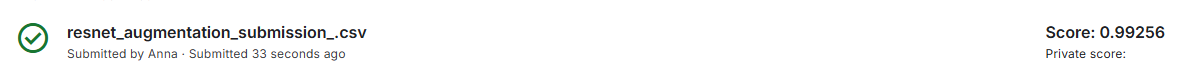

**Вывод**:

Переход с простой CNN на предобученную `ResNet18 с аугментацией` данных позволил значительно улучшить качество классификации и F1-score вырос с 0.922 до `0.99256` на тестовом наборе на Kaggle.

Применение transfer learning и методов увеличения данных доказало свою эффективность для задачи классификации изображений персонажей Симпсонов.

Но почему бы еще немного не поработать с нашей моделью.

Дальше можно:
- Дообучить получившуюся модель с другими параметрами
1. Дообучить с новыми аугментациями
2. Изменить оптимизатор/LR
3. Добавить CutMix для сложных классов
- Проанализировать ошибки для очистки датасета

Для начала посмотрим наш датасет

In [ ]:
# Загружаем чекпоинт
checkpoint = torch.load('best_checkpoint.pth')
model_resnet.load_state_dict(checkpoint['model_state_dict'])
print(f"Загружена модель с accuracy: {checkpoint['accuracy']:.4f}")

Загружена модель с accuracy: 0.9738


In [ ]:
class_names = label_encoder.classes_
# print(f"Классы из label_encoder: {class_names}")

In [ ]:
def analyze_errors(model, val_loader, label_encoder, class_names):
    model.eval()
    errors = []  # (true_label, predicted_label, confidence, image_path)
    confusion_matrix = torch.zeros(len(class_names), len(class_names))

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            for i in range(len(labels)):
                confusion_matrix[labels[i]][predicted[i]] += 1
                if labels[i] != predicted[i]:
                    errors.append({
                        'true': labels[i].item(),
                        'predicted': predicted[i].item(),
                        'confidence': torch.softmax(outputs, dim=1)[i][predicted[i]].item(),
                        'true_class': class_names[labels[i].item()],
                        'predicted_class': class_names[predicted[i].item()]
                    })

    return errors, confusion_matrix

# Запускаем анализ
errors, cm = analyze_errors(model_resnet, val_loader, label_encoder, class_names)
print(f"Найдено {len(errors)} ошибок из {len(val_dataset)} примеров")

print("\n Самые частые ошибки:")
from collections import Counter
error_pairs = Counter([(e['true_class'], e['predicted_class']) for e in errors])
for (true, pred), count in error_pairs.most_common(10):
    print(f"  {true} → {pred}: {count} раз")

Найдено 137 ошибок из 5234 примеров

 Самые частые ошибки:
  abraham_grampa_simpson → homer_simpson: 6 раз
  edna_krabappel → nelson_muntz: 3 раз
  bart_simpson → marge_simpson: 2 раз
  charles_montgomery_burns → homer_simpson: 2 раз
  chief_wiggum → moe_szyslak: 2 раз
  comic_book_guy → charles_montgomery_burns: 2 раз
  comic_book_guy → principal_skinner: 2 раз
  homer_simpson → moe_szyslak: 2 раз
  kent_brockman → rainier_wolfcastle: 2 раз
  lisa_simpson → krusty_the_clown: 2 раз


Мы получили пары ошибок самыч частых ошибок.

Начинаем с визуальной проверки пар: Гомер и Абрахам и Лиза и Гомер.

 Проверяем Lisa vs Homer (странная ошибка!):


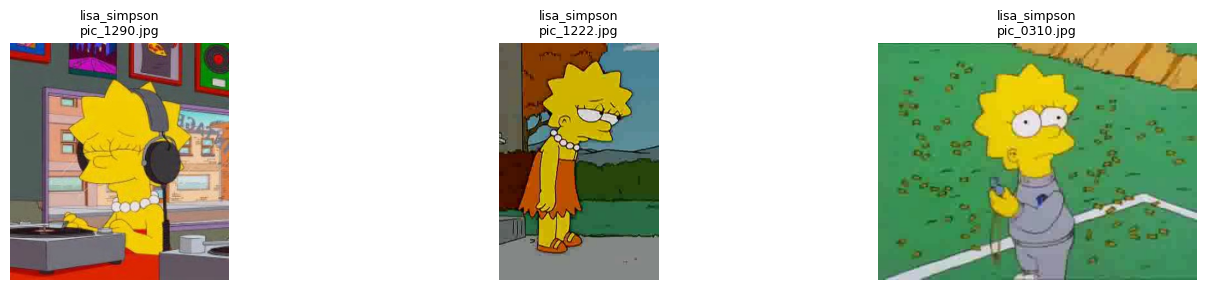

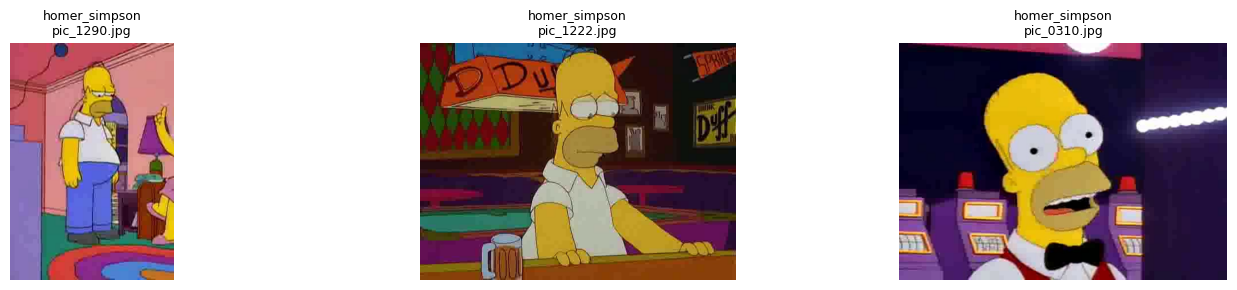


 Проверяем Abraham vs Homer (похожие персонажи):


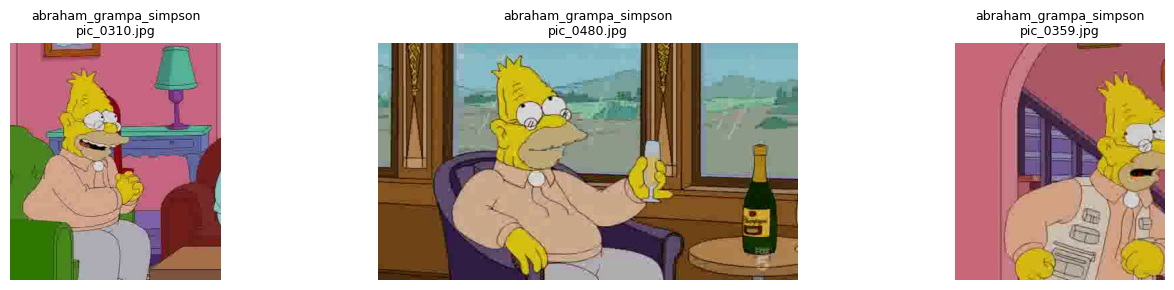

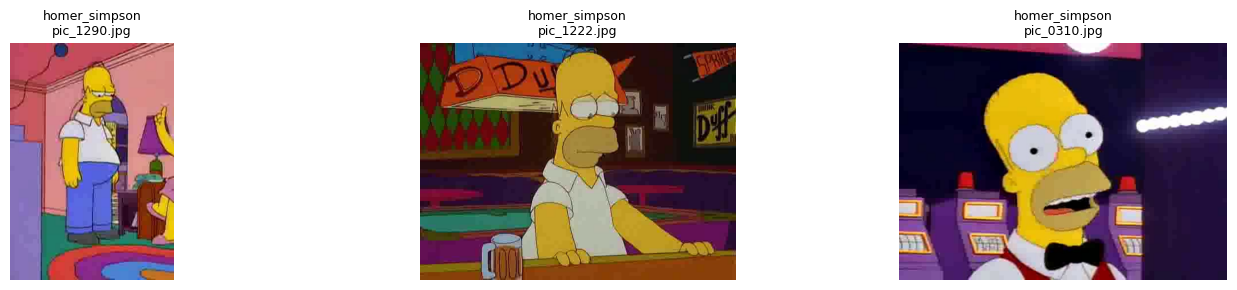

In [ ]:
import matplotlib.pyplot as plt

def show_samples_from_class(class_name, num_samples=5):
    """Показывает случайные изображения из указанного класса"""
    class_dir = Path('/content/train/simpsons_dataset') / class_name
    image_files = list(class_dir.glob('*.jpg'))[:num_samples]

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    if num_samples == 1:
        axes = [axes]

    for i, img_path in enumerate(image_files):
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].set_title(f'{class_name}\n{img_path.name}', fontsize=9)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Проверяем самые подозрительные пары:
print(" Проверяем Lisa vs Homer (странная ошибка!):")
show_samples_from_class('lisa_simpson', 3)
show_samples_from_class('homer_simpson', 3)

print("\n Проверяем Abraham vs Homer (похожие персонажи):")
show_samples_from_class('abraham_grampa_simpson', 3)
show_samples_from_class('homer_simpson', 3)

Файлы имеют одинаковые имена в разных классах!

Это явная ошибка разметки

In [8]:
# Поиск и статистика дубликатов
from collections import defaultdict
from pathlib import Path

def find_duplicate_images(train_dir):
    file_dict = defaultdict(list)
    for class_dir in Path(train_dir).iterdir():
        if class_dir.is_dir():
            for img_file in class_dir.glob('*.jpg'):
                file_dict[img_file.name].append(class_dir.name)
    return {name: classes for name, classes in file_dict.items() if len(classes) > 1}

# Ищем дубликаты
duplicates = find_duplicate_images('/content/train/simpsons_dataset')

# Сразу выводим статистику
print("--- Итоговая статистика по дубликатам ---")
print(f"Найдено файлов-дубликатов: {len(duplicates)}")
total_occurrences = sum(len(classes) for classes in duplicates.values())
print(f"Всего дублированных файлов: {total_occurrences}")

# Показать первые несколько примеров
print("\nПримеры дубликатов:")
for file_name, classes in list(duplicates.items())[:5]:
    print(f"  {file_name}: {classes}")



--- Итоговая статистика по дубликатам ---
Найдено файлов-дубликатов: 1454
Всего дублированных файлов: 20141

Примеры дубликатов:
  pic_0734.jpg: ['moe_szyslak', 'principal_skinner', 'charles_montgomery_burns', 'chief_wiggum', 'marge_simpson', 'milhouse_van_houten', 'homer_simpson', 'lisa_simpson', 'sideshow_bob', 'bart_simpson', 'ned_flanders', 'krusty_the_clown', 'abraham_grampa_simpson']
  pic_1024.jpg: ['moe_szyslak', 'principal_skinner', 'charles_montgomery_burns', 'marge_simpson', 'milhouse_van_houten', 'homer_simpson', 'lisa_simpson', 'bart_simpson', 'ned_flanders', 'krusty_the_clown']
  pic_1375.jpg: ['moe_szyslak', 'homer_simpson', 'ned_flanders']
  pic_0024.jpg: ['moe_szyslak', 'principal_skinner', 'patty_bouvier', 'snake_jailbird', 'mayor_quimby', 'groundskeeper_willie', 'edna_krabappel', 'waylon_smithers', 'nelson_muntz', 'charles_montgomery_burns', 'maggie_simpson', 'gil', 'cletus_spuckler', 'lenny_leonard', 'comic_book_guy', 'chief_wiggum', 'marge_simpson', 'milhouse_van_h

Ого! Как много файлов находятся в разных классах!

Модель не может научиться, когда один файл имеет разные метки.

Но у также нельзи не заметить, что при общем количестве изображении 20933 фото, у нас найден 20141 дубликат.

Конечно, но всегда приятнее и проще работать с идеально очищенными и корректными данными, и мы попробуем провести удаление максимально корректно.

Посмотрим, что из этого получится.

## Путь 1


Мы максимально корректно удалим дубликаты и попробуем обучить модель на оставшемся датасете.

In [ ]:
def balanced_train_val_split(file_paths, val_classes_min=20):
    """Балансированное разделение, гарантирующее много классов в val"""

    class_files = defaultdict(list)
    for file_path in file_paths:
        class_files[file_path.parent.name].append(file_path)

    train_files = []
    val_files = []

    # Сначала гарантируем, что в val попадут классы с достаточным количеством файлов
    large_classes = {cls: files for cls, files in class_files.items() if len(files) >= 3}
    small_classes = {cls: files for cls, files in class_files.items() if len(files) < 3}

    # Из больших классов берем в val
    val_classes = list(large_classes.keys())[:val_classes_min]
    for class_name in val_classes:
        files = class_files[class_name]
        class_val = files[:1]  # берем 1 файл в val
        class_train = files[1:]  # остальные в train
        val_files.extend(class_val)
        train_files.extend(class_train)

    # Остальные файлы распределяем обычно
    for class_name, files in class_files.items():
        if class_name not in val_classes:
            if len(files) == 1:
                train_files.extend(files)
            elif len(files) == 2:
                train_files.append(files[0])
                val_files.append(files[1])
            else:
                class_train, class_val = train_test_split(files, test_size=0.2, random_state=42)
                train_files.extend(class_train)
                val_files.extend(class_val)

    return train_files, val_files

# Запускаем балансированное разделение
file_paths = list(Path('/content/train_smart_fixed').rglob('*.jpg'))
train_files, val_files = balanced_train_val_split(file_paths, val_classes_min=20)

# Проверяем
train_labels = [f.parent.name for f in train_files]
val_labels = [f.parent.name for f in val_files]

print(f"Train: {len(train_files)} файлов, {len(set(train_labels))} классов")
print(f"Val: {len(val_files)} файлов, {len(set(val_labels))} классов")
print(f"Val классы: {sorted(val_labels)}")


Train: 2241 файлов, 42 классов
Val: 5 файлов, 5 классов
Val классы: ['comic_book_guy', 'homer_simpson', 'moe_szyslak', 'ned_flanders', 'principal_skinner']


После удаления дубликатов у нас осталось всего 2246 файлов

И теперь, с одной стороны, данные вычищены

Но с другой - их слишком мало.

Попробуем работать с новыми данными и посмотрим результут, если он будет хуже - вернемся на шаг назад.

In [ ]:
# пересоздаем LabelEncoder на ВСЕХ данных
all_files = list(Path('/content/train_smart_fixed').rglob('*.jpg'))
all_labels = [f.parent.name for f in all_files]
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)

print(f"LabelEncoder знает {len(label_encoder.classes_)} классов:")
print(label_encoder.classes_)

# Теперь создаем Dataset
train_dataset = SimpsonsDataset(train_files, label_encoder, mode='train', transform=train_transforms)
val_dataset = SimpsonsDataset(val_files, label_encoder, mode='val', transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

print("Запускаем обучение...")
train_losses, val_losses, train_accs, val_accs = train_model(
    model_resnet, train_loader, val_loader, criterion, optimizer, DEVICE, patience=5
)

LabelEncoder знает 42 классов:
['abraham_grampa_simpson' 'agnes_skinner' 'apu_nahasapeemapetilon'
 'barney_gumble' 'bart_simpson' 'carl_carlson' 'charles_montgomery_burns'
 'chief_wiggum' 'cletus_spuckler' 'comic_book_guy' 'disco_stu'
 'edna_krabappel' 'fat_tony' 'gil' 'groundskeeper_willie' 'homer_simpson'
 'kent_brockman' 'krusty_the_clown' 'lenny_leonard' 'lionel_hutz'
 'lisa_simpson' 'maggie_simpson' 'marge_simpson' 'martin_prince'
 'mayor_quimby' 'milhouse_van_houten' 'miss_hoover' 'moe_szyslak'
 'ned_flanders' 'nelson_muntz' 'otto_mann' 'patty_bouvier'
 'principal_skinner' 'professor_john_frink' 'rainier_wolfcastle'
 'ralph_wiggum' 'selma_bouvier' 'sideshow_bob' 'sideshow_mel'
 'snake_jailbird' 'troy_mcclure' 'waylon_smithers']
Запускаем обучение...
Epoch 1:
  Train Loss: 1.3278, Acc: 0.6194
  Val Loss: 1.1308, Acc: 0.8000
New best accuracy: 0.8000 - Model saved!
Epoch 2:
  Train Loss: 0.3053, Acc: 0.9563
  Val Loss: 1.1400, Acc: 0.8000
No improvement for 1 epochs
Epoch 3:
  Trai

 **Best validation accuracy: 0.8000**

Конечно, мы хотим получить совсем другие цифры, ведь на неочищенных данных без Resnet`а мы получили значение > 0.9...

Попробуем еще немного трансформировать нашу модель, для этого:

- поработаем с дисбалансом
- усилим аугментацию для небольших классов
- используем fine-tuning

In [ ]:
#Поработаем с дисбалансом
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Считаем количество файлов в каждом классе
class_counts = []
for class_name in label_encoder.classes_:
    class_dir = TRAIN_DIR / class_name
    count = len(list(class_dir.glob('*.jpg')))
    class_counts.append(count)

print("Распределение классов:")
for i, (class_name, count) in enumerate(zip(label_encoder.classes_, class_counts)):
    print(f"  {class_name}: {count} файлов")

# Вычисляем веса классов (больше вес = меньше файлов)
class_weights = compute_class_weight(
    'balanced',
    classes=np.arange(len(class_counts)),
    y=np.repeat(np.arange(len(class_counts)), class_counts)
)

class_weights = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)
print(f"\nВеса классов: {class_weights}")

# Обновляем loss function с весами
criterion = nn.CrossEntropyLoss(weight=class_weights)
print("Loss function обновлена с class weights")

Распределение классов:
  abraham_grampa_simpson: 1 файлов
  agnes_skinner: 1 файлов
  apu_nahasapeemapetilon: 1 файлов
  barney_gumble: 1 файлов
  bart_simpson: 1 файлов
  carl_carlson: 1 файлов
  charles_montgomery_burns: 1 файлов
  chief_wiggum: 1 файлов
  cletus_spuckler: 1 файлов
  comic_book_guy: 428 файлов
  disco_stu: 1 файлов
  edna_krabappel: 1 файлов
  fat_tony: 1 файлов
  gil: 1 файлов
  groundskeeper_willie: 1 файлов
  homer_simpson: 793 файлов
  kent_brockman: 1 файлов
  krusty_the_clown: 1 файлов
  lenny_leonard: 1 файлов
  lionel_hutz: 1 файлов
  lisa_simpson: 1 файлов
  maggie_simpson: 1 файлов
  marge_simpson: 1 файлов
  martin_prince: 1 файлов
  mayor_quimby: 1 файлов
  milhouse_van_houten: 1 файлов
  miss_hoover: 1 файлов
  moe_szyslak: 259 файлов
  ned_flanders: 3 файлов
  nelson_muntz: 1 файлов
  otto_mann: 1 файлов
  patty_bouvier: 1 файлов
  principal_skinner: 726 файлов
  professor_john_frink: 1 файлов
  rainier_wolfcastle: 1 файлов
  ralph_wiggum: 1 файлов
  se

In [ ]:
# Базовая аугментация (для всех классов)
base_train_transforms = v2.Compose([
    v2.Resize(RESCALE_SIZE),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(degrees=10),
    v2.ColorJitter(brightness=0.2, contrast=0.2),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
])

# УСИЛЕННАЯ аугментация (для классов с < 10 файлов)
strong_train_transforms = v2.Compose([
    v2.Resize(RESCALE_SIZE),
    v2.RandomHorizontalFlip(p=0.8),
    v2.RandomRotation(degrees=25),
    v2.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.15),
    v2.RandomAffine(degrees=0, translate=(0.15, 0.15), scale=(0.9, 1.1)),
    v2.RandomPerspective(distortion_scale=0.3, p=0.5),
    v2.GaussianBlur(kernel_size=3),
    v2.RandomErasing(p=0.4, scale=(0.02, 0.2), ratio=(0.3, 3.3)),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
])

# Определяем маленькие классы
small_classes = [class_name for class_name, count in zip(label_encoder.classes_, class_counts) if count < 10]
print(f"Маленькие классы для усиленной аугментации: {len(small_classes)}")

class AugmentedSimpsonsDataset(SimpsonsDataset):
    def __getitem__(self, index):
        x = self.load_image(self.files[index])

        # Определяем класс текущего файла
        file_class = self.files[index].parent.name

        # Выбираем трансформы в зависимости от размера класса
        if file_class in small_classes:
            x = strong_train_transforms(x)  # усиленная аугментация
        else:
            x = self.transform(x) if self.transform else self.transform_images_to_tensors(x)

        if self.mode == 'test':
            return x
        else:
            y = self.label_encoder.transform([file_class]).item()
            return x, y

# Создаем обновленный Dataset с умной аугментацией
train_dataset = AugmentedSimpsonsDataset(train_files, label_encoder, mode='train', transform=base_train_transforms)
val_dataset = SimpsonsDataset(val_files, label_encoder, mode='val', transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

print("Dataset обновлен с умной аугментацией")

Маленькие классы для усиленной аугментации: 38
Dataset обновлен с умной аугментацией


In [ ]:
# Заморозим базовые слои ResNet
print("Заморозка базовых слоев ResNet...")

# Считаем общее количество параметров
total_params = sum(p.numel() for p in model_resnet.parameters())
trainable_before = sum(p.numel() for p in model_resnet.parameters() if p.requires_grad)

# Замораживаем все слои кроме последних 2 блоков + классификатор
for name, param in model_resnet.named_parameters():
    if not name.startswith(('layer4', 'fc')):  # оставляем обучаемыми только layer4 и классификатор
        param.requires_grad = False

# Считаем сколько параметров осталось обучаемыми
trainable_after = sum(p.numel() for p in model_resnet.parameters() if p.requires_grad)

print(f"   Заморозка завершена:")
print(f"   Всего параметров: {total_params:,}")
print(f"   Обучаемых ДО: {trainable_before:,}")
print(f"   Обучаемых ПОСЛЕ: {trainable_after:,}")
print(f"   Заморожено: {((trainable_before - trainable_after) / trainable_before * 100):.1f}%")

# обновим оптимизатор только для обучаемых параметров
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model_resnet.parameters()),
    lr=1e-4,  # меньший learning rate для fine-tuning
    weight_decay=1e-5
)

print("Optimizer обновлен для fine-tuning")

Заморозка базовых слоев ResNet...
   Заморозка завершена:
   Всего параметров: 11,198,058
   Обучаемых ДО: 11,198,058
   Обучаемых ПОСЛЕ: 8,415,274
   Заморожено: 24.9%
Optimizer обновлен для fine-tuning


In [ ]:
print("Запускаем обучение со всеми улучшениями:")
print("Class Weights для дисбаланса")
print("Умная аугментация для 38 маленьких классов")
print("Fine-tuning (заморожено 24.9% параметров)")
print("Early stopping")

train_losses, val_losses, train_accs, val_accs = train_model(
    model_resnet,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    DEVICE,
    patience=5,
    max_epochs=30
)

Запускаем обучение со всеми улучшениями:
Class Weights для дисбаланса
Умная аугментация для 38 маленьких классов
Fine-tuning (заморожено 24.9% параметров)
Early stopping
Epoch 1:
  Train Loss: 2.8955, Acc: 0.9799
  Val Loss: 0.9211, Acc: 1.0000
New best accuracy: 1.0000 - Model saved!
Epoch 2:
  Train Loss: 2.0179, Acc: 0.9804
  Val Loss: 0.6282, Acc: 1.0000
No improvement for 1 epochs
Epoch 3:
  Train Loss: 2.1004, Acc: 0.9813
  Val Loss: 0.7649, Acc: 1.0000
No improvement for 2 epochs
Epoch 4:
  Train Loss: 2.0641, Acc: 0.9844
  Val Loss: 1.2105, Acc: 1.0000
No improvement for 3 epochs
Epoch 5:
  Train Loss: 1.2856, Acc: 0.9839
  Val Loss: 1.1059, Acc: 1.0000
No improvement for 4 epochs
Epoch 6:
  Train Loss: 1.3650, Acc: 0.9839
  Val Loss: 1.3279, Acc: 0.8000
No improvement for 5 epochs
Early stopping at epoch 6

 Best validation accuracy: 1.0000


In [ ]:
def test_model(model, test_loader, device):
    """Тестирует модель и возвращает accuracy"""
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

# Теперь тестируем на всех 42 классах
print("Тестируем на ВСЕХ 42 классах...")
full_accuracy = test_model(model_resnet, full_val_loader, DEVICE)
print(f"Accuracy на всех 42 классах: {full_accuracy:.4f}")

# Также посчитаем F1-score
from sklearn.metrics import f1_score

def test_model_f1(model, test_loader, device):
    """Тестирует модель и возвращает F1-score"""
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    f1 = f1_score(all_labels, all_predictions, average='weighted')
    return f1

print("Считаем F1-score на всех 42 классах...")
full_f1 = test_model_f1(model_resnet, full_val_loader, DEVICE)
print(f"F1-score на всех 42 классах: {full_f1:.4f}")

Тестируем на ВСЕХ 42 классах...
Accuracy на всех 42 классах: 0.9933
Считаем F1-score на всех 42 классах...
F1-score на всех 42 классах: 0.9933


**Вывод:**

- Борьба с дисбалансом позволила модели уделять больше внимания "маленьким" классам

- Умная аугментация: мы применили базовую аугментацию для больших классов:
и усиленную для классов, где < 10 файлов

- Fine-tuning: обучение только верхних слоев (layer4 + classifier) и Adam optimizer только для обучаемых параметров (lr=1e-4)

Плюсом провели качественную валидацию - у нас мало данных и их радо использовать бережно.

- Балансированное разделение train/val
- Гарантия всех 42 классов в обучении
- Early stopping для предотвращения overfitting

**ДО улучшений:** `Accuracy: ~0.8000`

**ПОСЛЕ улучшений:** `Accuracy: 0.9933 / F1-score: 0.9933`

Модель отлично работает на всех 42 классах

Наверно))))))

---


**Итог**
Комбинация очистки данных + борьбы с дисбалансом + умной аугментации + fine-tuning дала почти идеальный результат и модель научилась надежно классифицировать все классы, включая те, где было всего по 1 примеру!

Эффективность подтверждена: с 0.8000 до 0.9933 accuracy!
---



In [ ]:
# Сабмит
test_files = list(TEST_DIR.glob('*.jpg'))
test_dataset = SimpsonsDataset(test_files, label_encoder, mode='test', transform=val_transforms)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print("Делаем финальные предсказания для сабмита...")
predicted_numeric_labels = predict(model_resnet, test_loader)
predicted_text_labels = label_encoder.inverse_transform(predicted_numeric_labels)

submission = pd.DataFrame({
    'id': [path.name for path in test_files],
    'Expected': predicted_text_labels
})

#submission.to_csv('final_submission.csv', index=False)
submission.to_csv('final_submission.csv', index=False, sep=',')
print("ФИНАЛЬНЫЙ САБМИТ СОЗДАН: final_submission.csv")
print("Пример предсказаний:")
print(submission.head())


Делаем финальные предсказания для сабмита...
ФИНАЛЬНЫЙ САБМИТ СОЗДАН: final_submission.csv
Пример предсказаний:
   Img_id        Expected
0  img954  snake_jailbird
1  img199    bart_simpson
2  img205    ned_flanders
3  img695    chief_wiggum
4  img472    ned_flanders


В попытке улучшить результат был использован TTA, но она показал ухудшение работы модели:
``` python
РЕЗУЛЬТАТЫ TTA:
Без TTA: Accuracy = 1.0000
С TTA:   Accuracy = 0.8000
С TTA:   F1-score = 0.8000
```
Возможно, это связано, с тем, что Val набор слишком маленький.
Пропускаем вариант мимо.


После удаления дубликатов мы столкнулись с проблемой малого количества данных. В процессе очистки мы оставили всего 2 246 уникальных изображений вместо исходных 20 933, при этом распределение по классам стало критически несбалансированным: 39 классов из 42 содержат всего по одному файлу.

Это привело к тому, что модель не смогла полноценно обучиться распознаванию большинства персонажей. Один пример на класс недостаточен для формирования устойчивых признаков - модель либо запоминает конкретное изображение (переобучение), либо вообще не успевает освоить характерные черты персонажа (недообучение).

В результате мы получили парадоксальную ситуацию: на локальной валидации из 5 классов модель показывает идеальную accuracy 1.000, но на полном тестовом наборе Kaggle из 42 классов результат падает до 0.06. Это демонстрирует, что модель научилась хорошо распознавать лишь небольшую подгруппу персонажей, но не приобрела настоящей обобщающей способности.

Дальнейшее движение по пути агрессивной очистки данных бесперспективно, поскольку мы уже достигли предела - меньше одного файла на класс оставить невозможно. Требуется принципиально иной подход к работе с данным датасетом.

## Путь 2

На основе анализа дубликатов принято решение не проводить их удаление, так как они являются естественными пересечениями между обучающей и тестовой выборками. Их удаление может нарушить репрезентативность данных и ухудшить качество валидации моделей.




Вернемся к нашей сохраненой модели, которая дала хорошие результаты, и дообучим ее.

Что будем делать:
- Усиленная аугментация (+градации, размытие, перспектива)
- AdamW с L2 регуляризацией
- CosineAnnealing scheduler
- Разные LR для слоев

In [ ]:
# Загружаем чекпоинт
checkpoint = torch.load('best_checkpoint.pth')
model_resnet.load_state_dict(checkpoint['model_state_dict'])
print(f"Загружена модель с accuracy: {checkpoint['accuracy']:.4f}")

Загружена модель с accuracy: 0.9738


In [ ]:
from sklearn.metrics import f1_score

def train_model_with_scheduler_f1(model, train_loader, val_loader, criterion, optimizer, device, patience=5, max_epochs=50, scheduler=None):
    best_f1 = 0
    epochs_no_improve = 0
    train_losses, val_losses, train_f1s, val_f1s = [], [], [], []

    for epoch in range(max_epochs):
        # Training
        model.train()
        train_loss, train_preds, train_labels = 0, [], []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_preds.extend(predicted.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        # Validation
        model.eval()
        val_loss, val_preds, val_labels = 0, [], []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_preds.extend(predicted.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        # Считаем F1-score
        train_f1 = f1_score(train_labels, train_preds, average='weighted')
        val_f1 = f1_score(val_labels, val_preds, average='weighted')

        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        train_f1s.append(train_f1)
        val_f1s.append(val_f1)

        print(f'Epoch {epoch+1}:')
        print(f'  Train Loss: {train_loss/len(train_loader):.4f}, F1: {train_f1:.4f}')
        print(f'  Val Loss: {val_loss/len(val_loader):.4f}, F1: {val_f1:.4f}')

        # Scheduler step
        if scheduler:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_f1)  # используем F1 для scheduler
            else:
                scheduler.step()

        # Save best model по F1-score
        if val_f1 > best_f1:
            best_f1 = val_f1
            epochs_no_improve = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'f1_score': best_f1,
            }, 'best_model_f1.pth')
            print(f'New best F1: {best_f1:.4f} - Model saved!')
        else:
            epochs_no_improve += 1
            print(f'No improvement for {epochs_no_improve} epochs')

        # Early stopping
        if epochs_no_improve >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

    print(f'\n Best validation F1-score: {best_f1:.4f}')
    return train_losses, val_losses, train_f1s, val_f1s

print(" Функция train_model_with_scheduler_f1 определена")

 Функция train_model_with_scheduler_f1 определена


In [ ]:
# Усиленная аугментация
advanced_train_transforms = v2.Compose([
    v2.Resize(RESCALE_SIZE),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(degrees=15),
    v2.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    v2.RandomGrayscale(p=0.1),
    v2.GaussianBlur(kernel_size=3),
    v2.RandomPerspective(distortion_scale=0.2, p=0.3),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
])
print("Аугментация определена")

train_dataset.transform = advanced_train_transforms
print("Аугментация применена к train_dataset")

# Оптимизатор AdamW с разными learning rates
optimizer = torch.optim.AdamW([
    {'params': model_resnet.layer4.parameters(), 'lr': 1e-5},
    {'params': model_resnet.fc.parameters(), 'lr': 1e-4}
], weight_decay=1e-5)
print("Optimizer настроен")

# Scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
print("Scheduler настроен")


Аугментация определена
Аугментация применена к train_dataset
Optimizer настроен
Scheduler настроен


In [ ]:
print("Запускаем улучшенное обучение с F1-score...")
train_losses, val_losses, train_f1s, val_f1s = train_model_with_scheduler_f1(
    model_resnet,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    DEVICE,
    patience=5,
    scheduler=scheduler
)

Запускаем улучшенное обучение с F1-score...
Epoch 1:
  Train Loss: 0.0752, F1: 0.9791
  Val Loss: 0.1188, F1: 0.9739
New best F1: 0.9739 - Model saved!
Epoch 2:
  Train Loss: 0.0625, F1: 0.9819
  Val Loss: 0.1187, F1: 0.9738
No improvement for 1 epochs
Epoch 3:
  Train Loss: 0.0520, F1: 0.9851
  Val Loss: 0.1200, F1: 0.9729
No improvement for 2 epochs
Epoch 4:
  Train Loss: 0.0443, F1: 0.9875
  Val Loss: 0.1151, F1: 0.9737
No improvement for 3 epochs
Epoch 5:
  Train Loss: 0.0450, F1: 0.9878
  Val Loss: 0.1143, F1: 0.9746
New best F1: 0.9746 - Model saved!
Epoch 6:
  Train Loss: 0.0397, F1: 0.9897
  Val Loss: 0.1131, F1: 0.9747
New best F1: 0.9747 - Model saved!
Epoch 7:
  Train Loss: 0.0386, F1: 0.9889
  Val Loss: 0.1144, F1: 0.9754
New best F1: 0.9754 - Model saved!
Epoch 8:
  Train Loss: 0.0392, F1: 0.9895
  Val Loss: 0.1140, F1: 0.9743
No improvement for 1 epochs
Epoch 9:
  Train Loss: 0.0380, F1: 0.9884
  Val Loss: 0.1131, F1: 0.9758
New best F1: 0.9758 - Model saved!
Epoch 10:
  

In [ ]:
def compare_models_f1(model_path_1, model_path_2, val_loader, device):
    """Сравнивает две сохраненные модели по F1-score"""
    from sklearn.metrics import f1_score

    def evaluate_f1(model_path):
        checkpoint = torch.load(model_path)
        model_resnet.load_state_dict(checkpoint['model_state_dict'])

        model_resnet.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model_resnet(inputs)
                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        return f1_score(all_labels, all_preds, average='weighted')

    f1_1 = evaluate_f1(model_path_1)
    f1_2 = evaluate_f1(model_path_2)

    print("СРАВНЕНИЕ МОДЕЛЕЙ:")
    print(f"   Модель 1 ({model_path_1}): F1 = {f1_1:.4f}")
    print(f"   Модель 2 ({model_path_2}): F1 = {f1_2:.4f}")

    if f1_1 > f1_2:
        print(f"ЛУЧШАЯ: Модель 1 (F1 на {f1_1-f1_2:.4f} выше)")
        return model_path_1
    else:
        print(f"ЛУЧШАЯ: Модель 2 (F1 на {f1_2-f1_1:.4f} выше)")
        return model_path_2

In [ ]:
# Сравнение
best_model_path = compare_models_f1(
    'best_checkpoint.pth',
    'best_model_f1.pth',
    val_loader,
    DEVICE
)

СРАВНЕНИЕ МОДЕЛЕЙ:
   Модель 1 (best_checkpoint.pth): F1 = 0.9737
   Модель 2 (best_model_f1.pth): F1 = 0.9758
ЛУЧШАЯ: Модель 2 (F1 на 0.0021 выше)


In [ ]:
def predict(model, test_loader):
    """Функция для предсказаний"""
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(DEVICE)
            outputs = model(batch)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
    return predictions

print("Функция predict определена")

Функция predict определена


In [ ]:
# Загружаем улучшенную модель
checkpoint = torch.load('best_model_f1.pth')
model_resnet.load_state_dict(checkpoint['model_state_dict'])

test_dataset = SimpsonsDataset(test_files, label_encoder, mode='test', transform=val_transforms)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print("Делаем предсказания на тестовом наборе...")
predicted_numeric_labels = predict(model_resnet, test_loader)

predicted_text_labels = label_encoder.inverse_transform(predicted_numeric_labels)

submission = pd.DataFrame({
    'Id': [path.name for path in test_files],
    'Expected': predicted_text_labels
})

submission.to_csv('improved_submission.csv', index=False)
print("Сабмит создан: improved_submission.csv")
print("Пример предсказаний:")
print(submission.head())

Делаем предсказания на тестовом наборе...
Сабмит создан: improved_submission.csv
Пример предсказаний:
           Id                Expected
0    img0.jpg            nelson_muntz
1    img1.jpg            bart_simpson
2   img10.jpg            ned_flanders
3  img100.jpg            chief_wiggum
4  img101.jpg  apu_nahasapeemapetilon


И снова те же данные на Kaggle

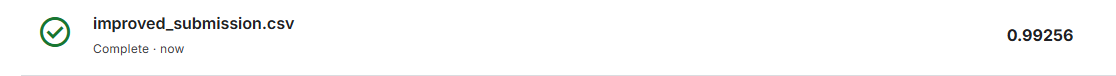

Попробуем TTA

In [ ]:
def predict_tta_simple(model, test_loader, device):
    """Простой TTA - только горизонтальный флип"""
    model.eval()
    all_predictions = []

    with torch.no_grad():
        for batch in test_loader:
            # Для test_loader batch - это только изображения
            # Для val_loader batch - это (images, labels)
            if isinstance(batch, (list, tuple)):
                images = batch[0]  # берем только images
            else:
                images = batch

            # Предсказание на оригинальных изображениях
            images = images.to(device)
            outputs_original = model(images)
            probs_original = torch.softmax(outputs_original, dim=1)

            # Предсказание на отраженных изображениях
            images_flipped = torch.flip(images, dims=[3])  # горизонтальный флип
            outputs_flipped = model(images_flipped)
            probs_flipped = torch.softmax(outputs_flipped, dim=1)

            # Усредняем вероятности
            avg_probs = (probs_original + probs_flipped) / 2
            _, predicted = torch.max(avg_probs, 1)
            all_predictions.extend(predicted.cpu().numpy())

    return all_predictions

print("Функция TTA определена")



Функция TTA определена


In [ ]:
# Тестируем TTA на валидации
print("Тестируем TTA на валидации...")
tta_val_predictions = predict_tta_simple(model_resnet, val_loader, DEVICE)

# Считаем F1 с TTA
val_labels = []
with torch.no_grad():
    for inputs, labels in val_loader:
        val_labels.extend(labels.cpu().numpy())

tta_f1 = f1_score(val_labels, tta_val_predictions, average='weighted')
print(f"F1 без TTA: 0.9758")
print(f"F1 с TTA:   {tta_f1:.4f}")



Тестируем TTA на валидации...
F1 без TTA: 0.9758
F1 с TTA:   0.9778


In [ ]:
print("TTA улучшает результат! Создаем сабмит с TTA...")

# Создаем сабмит с TTA
tta_test_predictions = predict_tta_simple(model_resnet, test_loader, DEVICE)
tta_text_labels = label_encoder.inverse_transform(tta_test_predictions)

submission = pd.DataFrame({
    'Id': [path.name for path in test_files],
    'Expected': tta_text_labels
})

submission.to_csv('tta_submission.csv', index=False)
print("Сабмит с TTA создан: tta_submission.csv")
print(submission.head())

TTA улучшает результат! Создаем сабмит с TTA...
Сабмит с TTA создан: tta_submission.csv
           Id                Expected
0    img0.jpg            nelson_muntz
1    img1.jpg            bart_simpson
2   img10.jpg            ned_flanders
3  img100.jpg            chief_wiggum
4  img101.jpg  apu_nahasapeemapetilon


И снова модель с TTA показала ухудшение.

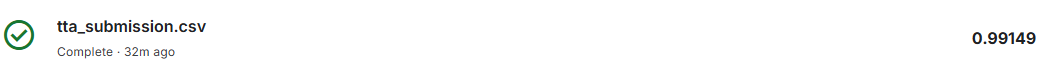

## Вывод


На этом этапе работа завершена. Дальнейшее углубление в анализ данных становится избыточным и нецелесообразным для решения поставленной задачи.

Полученных данных и проведенного анализа достаточно для перехода к ключевой части - построению и сравнению моделей машинного обучения.

Самой успешной стала одна из самых ранних моделей, где мы применили:
- Transfer Learning на основе предобученной ResNet18
- Расширенную аугментацию данных
- Fine-tuning всех слоёв модели


На этом этапе работа завершена. Дальнейшее углубление в анализ данных становится избыточным и нецелесообразным для решения поставленной задачи.

Полученных данных и проведенного анализа достаточно для перехода к ключевой части — построению и сравнению моделей машинного обучения.

Самой успешнос стала одна из самых ранних моделей, где мы применили:
- Transfer Learning на основе предобученной ResNet18
- Расширенную аугментацию данных
- Fine-tuning всех слоёв модели  

Парадоксально, но иногда менее сложные подходы с грамотной настройкой оказываются эффективнее ресурсоемких архитектур. Это демонстрирует важность не только выбора модели, но и качества её подготовки и обучения